In [39]:
import plotly.graph_objects as go
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.metrics.pairwise import rbf_kernel
import csv

In [40]:
n = 10
d1 = 250
d2 = 250
L = 20
seed = 4
np.random.seed(seed)

In [41]:
data_folder = f"data_{n}images_{d1}by{d2}pixels_upto{L}pins_{seed}seed/"

# delete the data folder if it already exists
if os.path.exists(data_folder) and os.path.isdir(data_folder):
    shutil.rmtree(data_folder)
    
# create a new data folder
os.makedirs(f"{data_folder}images")

In [42]:
# mean and covariance functions
a = 3
b = 12

# linear mean
def mean(p_1, p_2, z):
    return a * z[(p_1, p_2)] + b

# RBF kernel
def cov(p_1, p_2, z):
    return rbf_kernel(z[(p_1, p_2)])

In [43]:
header = ['image', 'pins', 'outputs']
with open(f"{data_folder}/pins.csv", 'w') as file:
    writer = csv.writer(file)
    writer.writerow(header)

# y_header = ['image', 'outputs']
# with open(f"{data_folder}/y.csv", 'w') as file:
#     y_writer = csv.writer(file)
#     y_writer.writerow(y_header)

for i in range(n):
    #these will generate the images
    c = np.random.randint(0, 10, size=4)
    func_list = [np.sin, np.cos]
    funcs = np.random.choice(func_list, 3)
    p1 = np.linspace(0, 5, d1)
    p2 = np.linspace(0, 5, d2)
    P1, P2 = np.meshgrid(p1, p2, indexing='ij')
    
    def f(P1, P2):
        return c[0] * funcs[0](P1) ** c[1] + c[2] * funcs[1](c[3] + P2 * P1) * funcs[2](P1)
    
    z = f(P1, P2)
    
    # indexing check
    # for i, vali in enumerate(p1):
    #     for j, valj in enumerate(p2):
    #         if z[i, j] != f(vali, valj):
    #             print("not equal!")
    
    fig = plt.figure(figsize=(7,7))
    plt.imshow(z, interpolation='nearest', origin='lower')
    # plt.colorbar()
    plt.axis('off')
    
    img_name = f"{i}.png"    
    fig.savefig(f'{data_folder}/images/{img_name}', bbox_inches='tight', pad_inches=0)
#     fig.canvas.draw()

#     # grab the pixel buffer and dump it into a numpy array
#     X = np.array(fig.canvas.renderer.buffer_rgba())
    
#     # saving an image using the imsave function

#     plt.imsave(f'{data_folder}/images/{img_name}', X)
    plt.close()
    
    # choose how many pins to sample
    L_i = np.random.randint(1, L)
    
    # coordinates of the pins
    p_1i = np.random.randint(d1, size=(L_i, 1))
    p_2i = np.random.randint(d2, size=(L_i, 1))
    # p_i = np.concatenate((p_1i, p_2i), axis=1) # coordinates of the pins
    p_i = list(zip(p_1i.reshape(L_i).tolist(), p_2i.reshape(L_i).tolist())) # coordinates of the pins
    
    mean_vec = mean(p_1i, p_2i, z)
    # print(mean_vec)
    # print(mean_vec.reshape(L_i))
    cov_mat = cov(p_1i, p_2i, z)
    
    y_i = np.random.multivariate_normal(mean_vec.reshape(L_i), cov_mat)

    with open(f"{data_folder}/pins.csv", 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([img_name, p_i, y_i.tolist()])
    # with open(f"{data_folder}/y.csv", 'a', newline='') as file:
    #     y_writer = csv.writer(file)
    #     y_writer.writerow([img_name, y_i.tolist()])

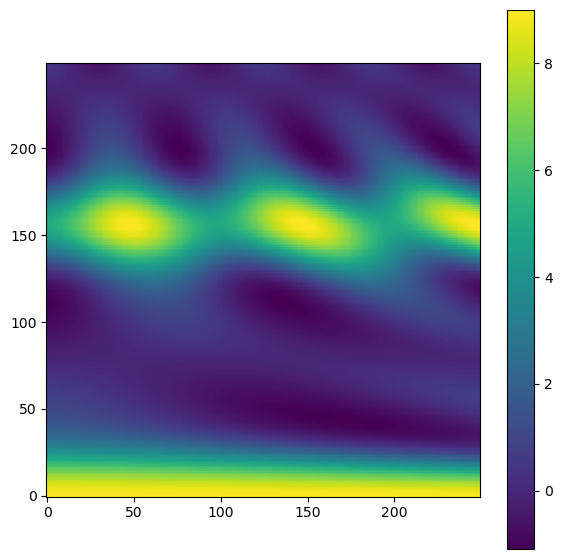

In [44]:
fig = plt.figure(figsize=(7,7))
# ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(z, interpolation='nearest', origin='lower')
plt.colorbar()
fig.canvas.draw()

# grab the pixel buffer and dump it into a numpy array
X = np.array(fig.canvas.renderer.buffer_rgba())

# saving an image using the imsave function
plt.imsave('sample.png', X)

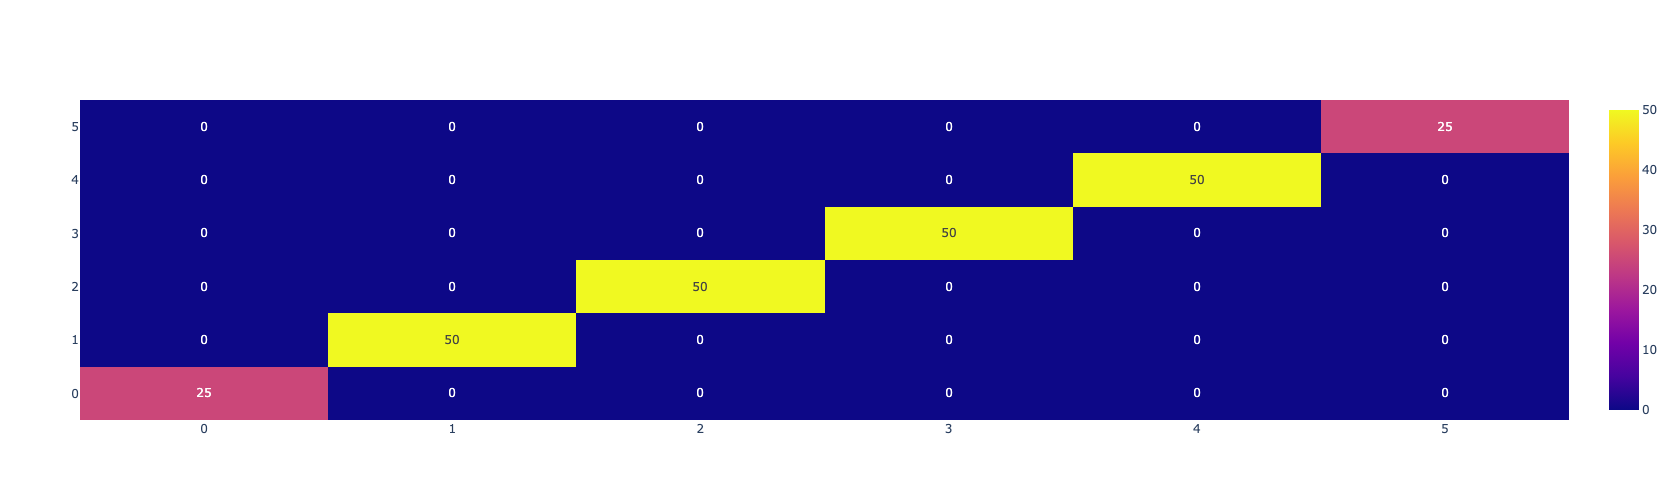

In [37]:
layout = go.Layout(width=500, height=500)

fig = go.Figure(go.Histogram2d(
        x=p1,
        y=p2,
        texttemplate= "%{z}",
    ), layout=layout) #, layout_xaxis_range=[-5, 5], layout_yaxis_range=[-5, 5])
fig.show()